# Klimadata v 0.1
Notatblokk som henter ned, behandlar og presenterar klimata for eit punkt.
Data hentast ned frå NVE sitt API GridTimeSeries. Data er frå SeNorge2 datasettet. Sjå senorge.no eller xgeo.no for datagrunnlag og forklaring på data.

Notatblokka samler data i pandas dataframes, og presenterer forhåndsdefinerte grafer. Det er relativt enkelt å lage til nye plot.
Notatblokka er delt inn i celler. Dersom det kun skal lagast til standard data er nok nok å gi inn koordinatar i UTM 33, samt stat og sluttdato

In [1]:
#Gi inn prosjektnavn
prosjektnavn = 'ershovdstolane'

#Gi in kordinater for posisjon og start og sluttdato for dataserien.
lon = 6771435  #NORD
lat = 137415     #ØST

#OBS!! Datoer for vinddata oppgis lenger ned i arket (eksister ikkje i like lang periode)
startdato = '1958-01-01' 
sluttdato = '2020-06-20'



### Det blir nytta ein rekke python bibliotek for å lage til plot og behandle data, desse blir importert i cella under:
Windrose, requests, folium og pyproj kjem ikkje standard med anaconda, og må innstallerast

In [2]:
#Importerer bibliotek for å behandle data og plotte.

import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from windrose import WindroseAxes
import requests
import datetime
import numpy as np
import folium
from folium.features import DivIcon
from pyproj import CRS
from pyproj import Transformer
%matplotlib inline


C:\Users\jan.aalbu\AppData\Local\Continuum\anaconda3\envs\R\lib\site-packages\windrose\windrose.py:29: MatplotlibDeprecationWarning: 
The Appender class was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  addendum = docstring.Appender(msg, "\n\n")
C:\Users\jan.aalbu\AppData\Local\Continuum\anaconda3\envs\R\lib\site-packages\windrose\windrose.py:30: MatplotlibDeprecationWarning: 
The copy_dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use docstring.copy() and cbook.dedent() instead.
  return lambda func: addendum(docstring.copy_dedent(base)(func))
C:\Users\jan.aalbu\AppData\Local\Continuum\anaconda3\envs\R\lib\site-packages\windrose\windrose.py:30: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.getdoc() instead.
  return lambda func: addendum(docstring.copy_dedent(base)(func))
C:\Users\jan.aalbu\AppData\Local\Continuum\anaconda3\envs\R\lib\site-packages\windrose\windrose

### For å henta inn data fra NVE er det laga ein liten funksjon som blir brukt for å hente ned dei forskjellige dataseriane

In [3]:
#Definisjon av funkssjoner
def nveApi2(lat, lon, startdato, sluttdato, para):
    '''
    Henter data frå NVE api GridTimeSeries
    input er lat, lon, dato og parameter for type data. UTM 33
    output er verdien i ei liste, men verdi per dag, typ nedbør osv..
    '''
    api = 'http://h-web02.nve.no:8080/api/'
    url = api + '/GridTimeSeries/' + str(lat) + '/' + str(lon) + '/' + str(startdato) + '/' + str(sluttdato) + '/' + para + '.json'
    r = requests.get(url)

    regn = r.json()
    return regn


Dersom det er behov for å sjå alle parmeter med data for tidsserien kan dette hentes ned ved å ta bort kommentar og køyre cella under.

In [4]:
#Henter ned alle datasett som er tilgjengelige
url = 'http://h-web02.nve.no:8080/api/GridTimeSeries/Themes/json'
r = requests.get(url)
theme = r.json()
navn = pd.DataFrame(theme)


In [5]:
#Transformerer UTM kordinater fra dataseriepunktet til WGS for å forenkle visning på kart under
transformer = Transformer.from_crs(5973, 4326)
trans_x, trans_y =  transformer.transform(lat, lon)

In [6]:
#Henter ned data frå NVE sitt API ved hjelp av nveApi2 funksjon
rr = nveApi2(lat, lon, startdato, sluttdato, 'rr') #Nedbør døgn
fsw = nveApi2(lat, lon, startdato, sluttdato, 'fsw') #Nysnø døgn
sdfsw3d = nveApi2(lat, lon, startdato, sluttdato, 'sdfsw3d') #Nynsø 3 døgn
sd = nveApi2(lat, lon, startdato, sluttdato, 'sd') #Snødybde
tm = nveApi2(lat, lon, startdato, sluttdato, 'tm') #Døgntemperatur

In [7]:
#Sjekk for kva høgde som er modellert for punktet som det blir tatt ut data for
altitude = rr['Altitude']
print('Høgde for klimapunktet: ' + str(altitude) + ' moh.')

Høgde for klimapunktet: 1253 moh.


### For å verifisere at det er valt riktig koordinat vises plasseringa på kartet under
Det er dessverre ikkje muleg å velge koordinat i eit punkt i kartet. Det står på TODO liste

In [8]:
#Lager kartvisning for å verifisere at koordinater er for riktig stad
m = folium.Map(location=[trans_x, trans_y], zoom_start=10) #Bruker transformerte koordinater (ikkej funne ut korleis bruke UTM med folium)
folium.Circle(
    radius=1000,
    location=[trans_x, trans_y],
    fill=False,
).add_to(m)
#Legger til Norgeskart WMS
folium.raster_layers.WmsTileLayer(
    url='https://opencache.statkart.no/gatekeeper/gk/gk.open_gmaps?layers=topo4&zoom={z}&x={x}&y={y}',
    name='Norgeskart',
    fmt='image/png',
    layers='topo4',
    attr=u'<a href="http://www.kartverket.no/">Kartverket</a>',
    transparent=True,
    overlay=True,
    control=True,
    
).add_child(folium.Popup('My name is Circle')).add_to(m)

m

In [9]:
#Lager datoer for x-akse
#TODO: referere til oppgitte datoer istaden for å hardkode ein dato her på nytt!!
start = datetime.datetime(int(startdato[0:4]), int(startdato[5:7]), int(startdato[8:10]))#'1960-01-01' 
end = datetime.datetime(int(sluttdato[0:4]), int(sluttdato[5:7]), int(sluttdato[8:10]))

#Etablerer pandas dataframe frå rr liste
df = pd.DataFrame(rr['Data'])
df['dato'] = pd.date_range(start, end) #Lager kolonne med datoer
df.rename({0 : rr['Theme']}, axis=1, inplace=True) #Gir nytt navn til rr kolonna
df.set_index('dato', inplace=True) #Setter datokolonna til indexkolonna, slik at det går an å bruke grouperfunksjon for å sortere på tidsserie

#Etablerer kolonner i dataframefor andre parameter
df[fsw['Theme']] = fsw['Data'] 
df[sd['Theme']] = sd['Data']
df[sdfsw3d['Theme']] = sdfsw3d['Data']
df[tm['Theme']] = tm['Data']
df['rr3'] = df.rr.rolling(3).sum() #Summerer siste 3 døgn 
df[df > 60000] = 0


In [10]:
#Lager dataframes for å presentere maksimal, gjennomsnittilig og minimal døgnlig nedbør og snømengde

dag = df['sd'].groupby(df.index.strftime('%m-%d')).mean()
dag_sd_df = dag.to_frame()
dagtm = df['tm'].groupby(df.index.strftime('%m-%d')).mean()
dag_tm_df = dagtm.to_frame()
dag_tm_df['tm_min'] = df['tm'].groupby(df.index.strftime('%m-%d')).min()
dag_tm_df['tm_max'] = df['tm'].groupby(df.index.strftime('%m-%d')).max()
dag_sd_df['sd_max'] = df['sd'].groupby(df.index.strftime('%m-%d')).max()
dag_sd_df['sd_min'] = df['sd'].groupby(df.index.strftime('%m-%d')).min()


In [11]:
#Lager dataframe med månedsvise mengder av temperatur og nedbør GRAF1
#df['month'] = pd.DatetimeIndex(df.index).month #Lager ei kolonne med månedsnummer

mon_rr = df['rr'].groupby(pd.Grouper(freq='M')).sum() #Grupperer nedbør etter måneder per år og summerer
mon_tm = df['tm'].groupby(pd.Grouper(freq='M')).mean() #Grupperer temperatur etter måneder per år og tar snitt
month_rr = mon_rr.to_frame() #Lager dataframe, unødvendig? Eklere å plotte?
month_tm = mon_tm.to_frame() #Lager dataframe, unødvendig? Eklere å plotte?
month_rr['m'] = pd.DatetimeIndex(month_rr.index).month #lager kolonne for månedsnummer
month_tm['m'] = pd.DatetimeIndex(month_tm.index).month #Lager kolonne for månedsnummer
month_mean_tm = month_tm.groupby(['m']).mean()


In [12]:
#Finner absoluttdato for maksimal snøhøgde
maksimal_snodato = df['sd'].idxmax().date() 
maksimal_sno = df['sd'].max()
maksimal_rrdato = df['rr'].idxmax().date()
maksimal_rr = df['rr'].max()
maksimal_sdfsw3ddato = df['sdfsw3d'].idxmax().date()
maksimal_sdfsw3d = df['sdfsw3d'].max()
print(maksimal_snodato)
print(maksimal_sno)

2007-03-18
197.6


In [13]:
#lager til data for plott med årsnedbør GRAF 2
aar = df['rr'].groupby(pd.Grouper(freq='Y')).sum() #Summerer all nedbør iløpet av eit år
aar_df = aar.to_frame() #Lager dataframe
snitt = aar_df['rr'].mean() #Lager snitt av nedbør
aar_df['snitt'] = snitt #Lager kolonne med snittverdi for plotting

In [14]:
#Lager data for å vise maksimal årlig døgnnedbør og 3d nedbør
maxrrsd3 = df['sdfsw3d'].groupby(pd.Grouper(freq='Y')).max()  #3 døgns snømengde
maxrr = df['rr'].groupby(pd.Grouper(freq='Y')).max()
maxrr3 = df['rr3'].groupby(pd.Grouper(freq='Y')).max()
maxrr_df = pd.concat ([maxrr, maxrr3, maxrrsd3], axis=1)


In [15]:
#Lager dataframe for å samle snødjupne
sno = df['sd'].groupby(pd.Grouper(freq='Y')).max() #Finner maksimal snødjupne per år
sno_df = sno.to_frame() #Lager pandas series om til dataframe
maxaar = sno_df.idxmax() #Finner året med maksimal snømengde
snomax = sno_df.max() #Finner maksimal snømengde
snosnitt = sno_df['sd'].mean() #Finner snitt snømengd
sno_df['snitt'] = snosnitt #Lager kolonne med snittmengde for å plotte strek i graf
maxstr = str(maxaar)[5:15] #Klipper til streng for å vise makspunkt i graf
maxsno = str(snomax)[5:12] #Klipper til streng for å vise makspunkt i graf
anotstring = str(maksimal_snodato) + ' | ' + str(maksimal_sno) + 'cm' #Lager sammensatt streng

## Setter opp plotting av grafer

C:\Users\jan.aalbu\AppData\Local\Continuum\anaconda3\envs\R\lib\site-packages\matplotlib\axes\_axes.py:2180: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  dx = [convert(x0 + ddx) - x for ddx in dx]


Text(50, 0, '1975-12-23 | 39.9 mm')

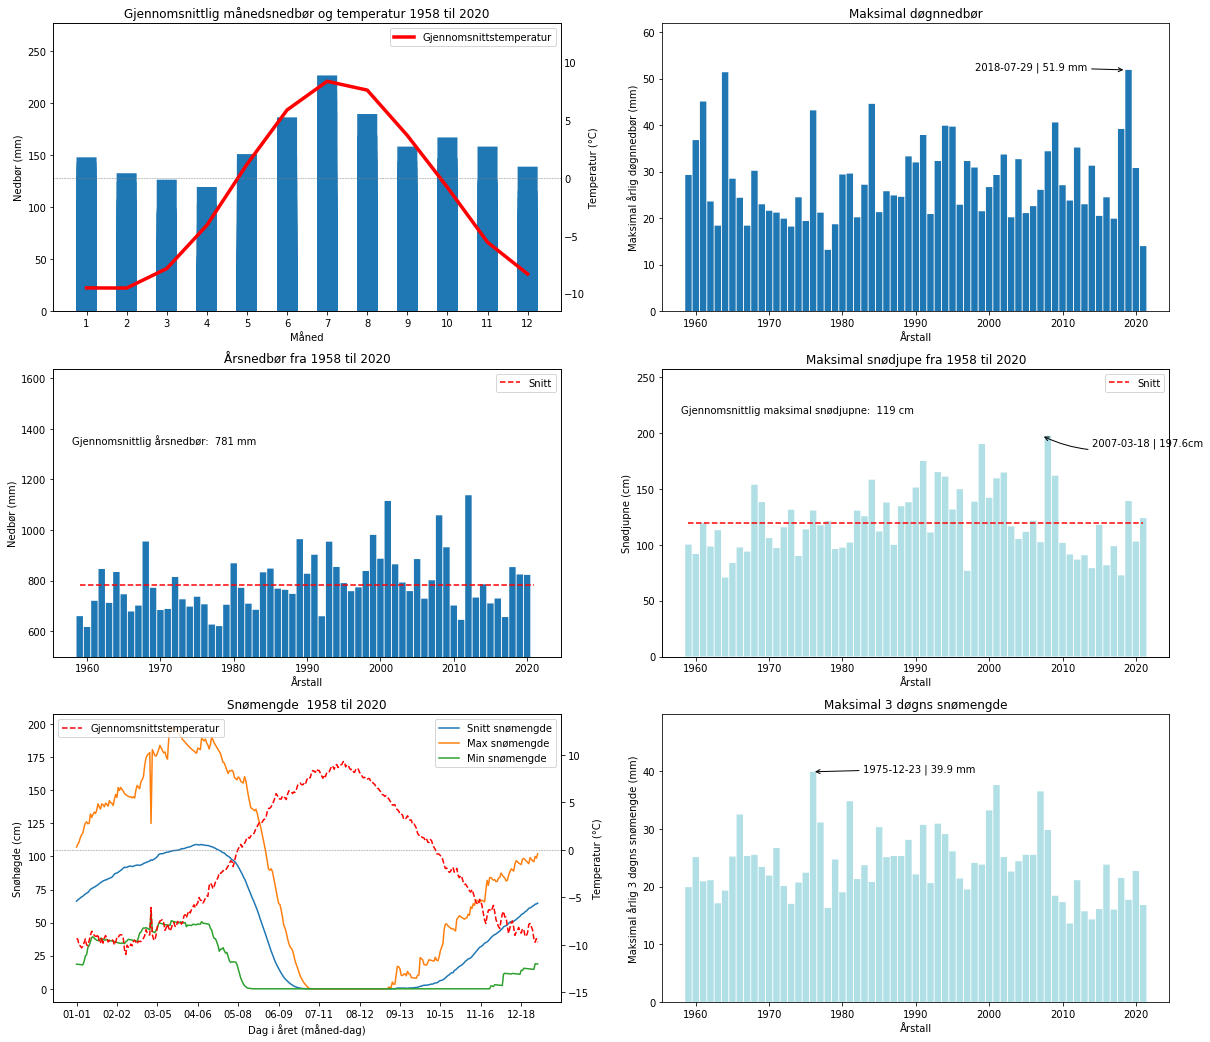

In [16]:


#Setter opp samleplot
fig, axs = plt.subplots(3,2, figsize=(20, 18))

#Plotter fyste plot
axs[0,0].set_title('Gjennomsnittlig månedsnedbør og temperatur ' + startdato[0:4] + ' til ' + sluttdato[0:4])
axs[0,0].bar(month_rr['m'], month_rr['rr'], width=0.5, snap=False)
axs[0,0].set_xlabel('Måned')
axs[0,0].set_ylabel('Nedbør (mm)')
axs[0,0].set_ylim(0, month_rr['rr'].max()+50)
#ax1.text('1960', aar_df['rr'].max()+20, "Gjennomsnittlig månedsnedbør:  " + str(int(snitt)) + ' mm')

ax2 = axs[0,0].twinx()#Setter ny akse på høgre side 
ax2.plot(month_mean_tm.index, month_mean_tm['tm'], 'r', label='Gjennomsnittstemperatur', linewidth=3.5)
ax2.set_ylim(month_mean_tm['tm'].min()-2, month_mean_tm['tm'].max()+5)
ax2.axhline(0, linestyle='--', color='grey', linewidth=0.5)
ax2.set_ylabel(u'Temperatur (\u00B0C)')
ax2.yaxis.set_tick_params(length=0)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax2.get_yaxis().set_visible(True)
ax2.legend()


axs[1,0].set_title('Årsnedbør fra ' + startdato[0:4] + ' til ' + sluttdato[0:4])
axs[1,0].bar(aar_df.index,  aar_df['rr'], width=320, snap=False) #Width er litt vanseklig, dersom ei søyle har bredde 365 dekker den "heile bredden", det er det samme som eit år, da x-aksen er delt opp i år..
axs[1,0].set_xlabel('Årstall')
axs[1,0].set_ylabel('Nedbør (mm)')
axs[1,0].set_ylim(500, aar_df['rr'].max()+500)
axs[1,0].text(startdato[0:4], aar_df['rr'].max()+200, "Gjennomsnittlig årsnedbør:  " + str(int(snitt)) + ' mm')

ax3 = axs[1,0].twinx()
ax3.plot(aar_df.index, aar_df['snitt'], 'r--', label='Snitt')
ax3.set_ylim(500, aar_df['rr'].max()+500)
ax3.get_yaxis().set_visible(False)
ax3.legend()


axs[1,1].set_title('Maksimal snødjupe fra ' + startdato[0:4] + ' til ' + sluttdato[0:4])
axs[1,1].bar(sno_df.index, sno_df['sd'], width=320, snap=False, color='powderblue') 
axs[1,1].set_xlabel('Årstall')
axs[1,1].set_ylabel('Snødjupne (cm)')
axs[1,1].set_ylim(0, sno_df['sd'].max()+60)
#ax1.text(maxaar, snomax, "Maksimal snødjupne:  " + str(snomax) + ' cm')
axs[1,1].annotate(anotstring, xy=(maksimal_snodato, maksimal_sno),  xycoords='data',
            xytext=(50, -10), textcoords='offset points',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2"))

ax4 = axs[1,1].twinx()
ax4.plot(sno_df.index, sno_df['snitt'], 'r--', label='Snitt')
ax4.set_ylim(0, sno_df['sd'].max()+60)
ax4.get_yaxis().set_visible(False)
ax4.text(startdato[0:4], df['sd'].max()+20, "Gjennomsnittlig maksimal snødjupne:  " + str(int(snosnitt)) + ' cm')
ax4.legend()

axs[0,1].set_title('Maksimal døgnnedbør')
axs[0,1].bar(maxrr_df.index, maxrr_df['rr'], width=320, snap=False)
axs[0,1].set_xlabel('Årstall')
axs[0,1].set_ylabel('Maksimal årlig døgnnedbør (mm)')
axs[0,1].set_ylim(0, maxrr_df['rr'].max()+10)
axs[0,1].annotate((str(maksimal_rrdato) + ' | ' + str(maksimal_rr) + ' mm'), xy=(maksimal_rrdato, maksimal_rr),  xycoords='data',
            xytext=(-150, 0), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"))


axs[2,0].plot(dag_sd_df.index, dag_sd_df['sd'], label='Snitt snømengde')
axs[2,0].plot(dag_sd_df.index, dag_sd_df['sd_max'], label='Max snømengde')
axs[2,0].plot(dag_sd_df.index, dag_sd_df['sd_min'], label='Min snømengde')
axs[2,0].xaxis.set_major_locator(MultipleLocator(32))
#ax1.xaxis.set_major_formatter(FormatStrFormatter('%m'))
axs[2,0].set_title('Snømengde  ' + startdato[0:4] + ' til ' + sluttdato[0:4])
axs[2,0].set_xlabel('Dag i året (måned-dag)')
axs[2,0].set_ylabel('Snøhøgde (cm)')
axs[2,0].legend()

ax4 = axs[2,0].twinx()
ax4.plot(dag_tm_df.index, dag_tm_df['tm'], 'r--', label='Gjennomsnittstemperatur')
ax4.xaxis.set_major_locator(MultipleLocator(32))
ax4.legend(loc='upper left')
ax4.set_ylim(dag_tm_df['tm'].min()-5, dag_tm_df['tm'].max()+5)
ax4.axhline(0, linestyle='--', color='grey', linewidth=0.5)
ax4.set_ylabel(u'Temperatur (\u00B0C)')

# axs[2,1].plot(dag_tm_df.index, dag_tm_df['tm'], label='Snitt temperatur')
# axs[2,1].plot(dag_tm_df.index, dag_tm_df['tm_max'], label='Max temperatur')
# axs[2,1].plot(dag_tm_df.index, dag_tm_df['tm_min'], label='Min temperatur')
# axs[2,1].xaxis.set_major_locator(MultipleLocator(32))
# #axs[2,1].xaxis.set_major_formatter(FormatStrFormatter('%d')) 
# axs[2,1].set_title('Temperatur  ' + startdato[0:4] + ' til ' + sluttdato[0:4])
# axs[2,1].set_xlabel('Dag i året (måned-dag)')
# axs[2,1].set_ylabel(u'Temperatur (\u00B0C)')
# axs[2,1].axhline(0, linestyle='--', color='grey', linewidth=0.5)
# axs[2,1].legend()

axs[2,1].set_title('Maksimal 3 døgns snømengde')
axs[2,1].bar(maxrr_df.index, maxrr_df['sdfsw3d'], width=320, snap=False, color='powderblue')
axs[2,1].set_xlabel('Årstall')
axs[2,1].set_ylabel('Maksimal årlig 3 døgns snømengde (mm)')
axs[2,1].set_ylim(0, maxrr_df['sdfsw3d'].max()+10)
axs[2,1].annotate((str(maksimal_sdfsw3ddato) + ' | ' + str(maksimal_sdfsw3d) + ' mm'), xy=(maksimal_sdfsw3ddato, maksimal_sdfsw3d),  xycoords='data',
            xytext=(50, 0), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"))

In [17]:
#Lagrer figuren
fig.savefig(f'klima_{prosjektnavn}.png')
sno_df['sd'].to_csv(f'{prosjektnavn}_maks_dogn_sno.txt', index=False, header=False) 
maxrr_df['rr'].to_csv(f'{prosjektnavn}_maks_dogn_nedbor.txt', index=False, header=False)
maxrr_df['rr3'].to_csv(f'{prosjektnavn}_maks_3dogn_nedbor.txt', index=False, header=False)
maxrr_df['sdfsw3d'].to_csv(f'{prosjektnavn}_maks_3dogn_sno.txt', index=False, header=False)

In [18]:
print(snitt)
jordskrednedbor8 = snitt * 0.08
jordskrednedbor5 = snitt * 0.05
print(jordskrednedbor5)
print(jordskrednedbor8)

781.6190476190477
39.08095238095239
62.529523809523816


In [19]:
#Vinddata - finnes kun i ein begrensa tidsperiode som grid data!
windDirection = nveApi2(lat, lon, '2018-03-01', '2019-12-31', 'windDirection10m24h06') #Vindretning for døgnet
windSpeed = nveApi2(lat, lon, '2018-03-01', '2019-12-31', 'windSpeed10m24h06')
rr_vind = nveApi2(lat, lon, '2018-03-01', '2019-12-31', 'rr')
tm_vind = nveApi2(lat, lon, '2018-03-01', '2019-12-31', 'tm')

#3 timersdata mot vind, fra 2018-03-01 til 2019-12-31
windDirection3h = nveApi2(lat, lon, '2018-03-01', '2019-12-31', 'windDirection10m3h')
windSpeed3h = nveApi2(lat, lon, '2018-03-01', '2019-12-31', 'windSpeed10m3h')
rr3h_vind = nveApi2(lat, lon, '2018-03-01', '2019-12-31', 'rr3h')
tm3h_vind = nveApi2(lat, lon, '2018-03-01', '2019-12-31', 'tm3h')

startwind = datetime.datetime(2018, 3, 1)
endwind = datetime.datetime(2019, 12, 31)

In [20]:
#Lager dataframe for daglig vindretning og styrke, sammen med nedbør?
dfw = pd.DataFrame(windDirection['Data']) #Henter inn verdiar for vindretning
dfw['dato'] = pd.date_range(startwind, endwind) #Lager til datoer som ikkje kjem automatisk frå NVE
dfw.rename({0 : windDirection['Theme']}, axis=1, inplace=True) #Gir nytt navn til kolonne med windretning
dfw.set_index('dato', inplace=True) #Setter dato som index i dataframe
dfw[windSpeed['Theme']] = windSpeed['Data']
dfw[rr_vind['Theme']] = rr_vind['Data']
dfw[tm_vind['Theme']] = tm_vind['Data']

dfwx = dfw.copy()
indexNames = dfw[dfw['windSpeed10m24h06'] <= 3].index
dfw.drop(indexNames , inplace=True)
indexNames = dfw[dfw['rr'] <= 5].index
dfw.drop(indexNames , inplace=True)
indexNames = dfw[dfw['tm'] >= 1].index
dfw.drop(indexNames , inplace=True)

#dfw[dfw > 60000] = 0
indexNames = dfwx[dfwx['windDirection10m24h06'] >= 1000].index
dfwx.drop(indexNames , inplace=True)
indexNames = dfwx[dfwx['windSpeed10m24h06'] >= 1000].index
dfwx.drop(indexNames , inplace=True)

In [21]:
#Lager dataframe med verdier for nedbør over 1 mm
dfwxrr = dfwx.copy()
indexNames = dfwxrr[dfwxrr['rr'] <= 5].index
dfwxrr.drop(indexNames , inplace=True)


In [22]:
#Lager dataframe og klargjer data for 3 timers data
dfw3 = pd.DataFrame(windDirection3h['Data'])
dfw3['dato'] = pd.date_range(startwind, endwind, freq='3h') #Lager til tidspunkt kvar 3. time
dfw3.rename({0 : windDirection3h['Theme']}, axis=1, inplace=True)
dfw3.set_index('dato', inplace=True)
dfw3[windSpeed3h['Theme']] = windSpeed3h['Data']
print(len(windSpeed3h['Data']))
#print(tm3h['Data'])
dfw3[rr3h_vind['Theme']] = rr3h_vind['Data']
dfw3['tm3h'] = tm3h_vind['Data']
dfw3[dfw3 > 60000] = 0
#dfw3

5361


In [23]:
print(360/8)
dfw['retning'] = dfw['windDirection10m24h06']*45


45.0


In [24]:
dfwx['retning'] = dfwx['windDirection10m24h06']*45
dfwxrr['retning'] = dfwxrr['windDirection10m24h06']*45

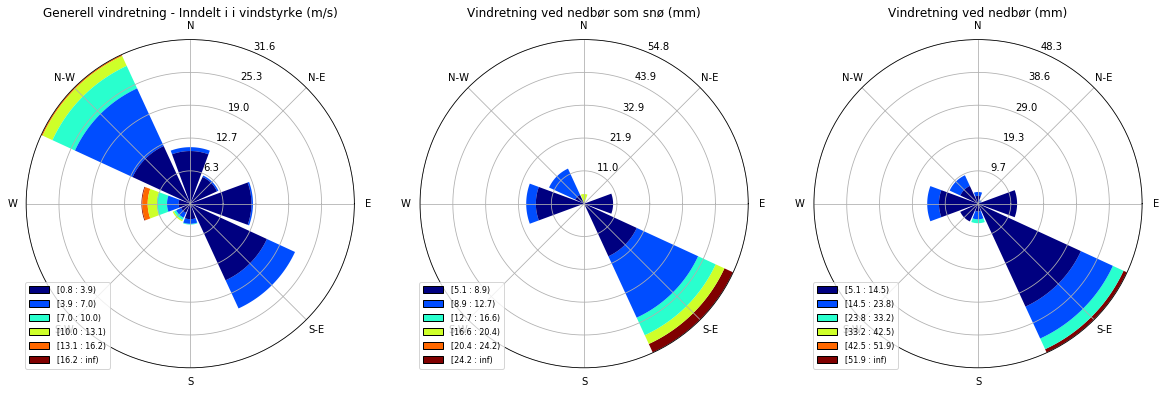

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, subplot_kw=dict(projection='windrose'), figsize=(20,20))

#ax1 = fig.add_subplot(111)
#ax2 = fig.add_subplot(112)
ax1.bar(dfwx['retning'], dfwx['windSpeed10m24h06'], normed=True, opening=1.8)
ax1.set_title('Generell vindretning - Inndelt i i vindstyrke (m/s)')
ax1.set_legend()
ax2.bar(dfw['retning'], dfw['rr'], normed=True,opening=1.8)
ax2.set_title('Vindretning ved nedbør som snø (mm)', )
ax2.set_legend()
ax3.bar(dfwxrr['retning'], dfwxrr['rr'], normed=True, opening=1.8)
ax3.set_title('Vindretning ved nedbør (mm)')
ax3.set_legend()


In [26]:
fig.savefig(f'vind_{prosjektnavn}.png')